In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [2]:
total_seconds = np.vectorize(datetime.timedelta.total_seconds)

def get_lonlat_geometry(geom):
    '''
    Returns lon/lat of all exteriors and interiors of a Shapely geomery:
        -Polygon
        -MultiPolygon
        -GeometryCollection
    '''
    lon = np.empty([0,1],dtype=float)
    lat = np.empty([0,1],dtype=float)
    if geom.geom_type == 'Polygon':
        lon_geom,lat_geom = get_lonlat_polygon(geom)
        lon = np.append(lon,lon_geom)
        lat = np.append(lat,lat_geom)
    elif geom.geom_type == 'MultiPolygon':
        polygon_list = [p for p in geom.geoms if p.geom_type == 'Polygon']
        for polygon in polygon_list:
            lon_geom,lat_geom = get_lonlat_polygon(polygon)
            lon = np.append(lon,lon_geom)
            lat = np.append(lat,lat_geom)
    elif geom.geom_type == 'GeometryCollection':
        polygon_list = [p for p in geom.geoms if p.geom_type == 'Polygon']
        for polygon in polygon_list:
            lon_geom,lat_geom = get_lonlat_polygon(polygon)
            lon = np.append(lon,lon_geom)
            lat = np.append(lat,lat_geom)
    return lon,lat

def get_lonlat_polygon(polygon):
    lon = np.empty([0,1],dtype=float)
    lat = np.empty([0,1],dtype=float)
    exterior_xy = np.asarray(polygon.exterior.xy)
    lon = np.append(lon,exterior_xy[0,:])
    lon = np.append(lon,np.nan)
    lat = np.append(lat,exterior_xy[1,:])
    lat = np.append(lat,np.nan)
    for interior in polygon.interiors:
        interior_xy = np.asarray(interior.coords.xy)
        lon = np.append(lon,interior_xy[0,:])
        lon = np.append(lon,np.nan)
        lat = np.append(lat,interior_xy[1,:])
        lat = np.append(lat,np.nan)
    return lon,lat

def get_lonlat_gdf(gdf):
    '''
    Returns lon/lat of all exteriors and interiors of a GeoDataFrame
    '''
    lon = np.empty([0,1],dtype=float)
    lat = np.empty([0,1],dtype=float)
    for geom in gdf.geometry:
        lon_geom,lat_geom = get_lonlat_geometry(geom)
        lon = np.append(lon,lon_geom)
        lat = np.append(lat,lat_geom)
    return lon,lat

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


In [3]:
atl12_file = '/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/ATL12/ATL12_TG_11_ATL12_FES2014_masked_20190921_DTU21_filtered_threshold_10_m.txt'
# atl12_file = '/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/ATL12/ATL12_TG_11_ATL12_GOT4p8_masked_20190921_DTU21_filtered_threshold_10_m.txt'
df_atl12 = pd.read_csv(atl12_file,header=None,names=['lon','lat','height','time'],dtype={'lon':'float','lat':'float','height':'float','time':'str'})

lon_atl12 = np.asarray(df_atl12.lon)
lat_atl12 = np.asarray(df_atl12.lat)
height_atl12 = np.asarray(df_atl12.height)
time_atl12 = np.asarray(df_atl12.time)

time_datetime_atl12 = np.asarray([datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f') for t in time_atl12])
time_days_atl12 = np.asarray([t.date() for t in time_datetime_atl12])
unique_days_atl12 = np.unique(time_days_atl12)
dt_atl12 = np.append(0,total_seconds(time_datetime_atl12[1:] - time_datetime_atl12[:-1]))
idx_new_day_atl12 = np.append(np.append(0,np.atleast_1d(np.argwhere(dt_atl12 > 3600).squeeze())),len(df_atl12))
unique_days_atl12_str = np.asarray([ud.strftime('%Y-%m-%d') for ud in unique_days_atl12])



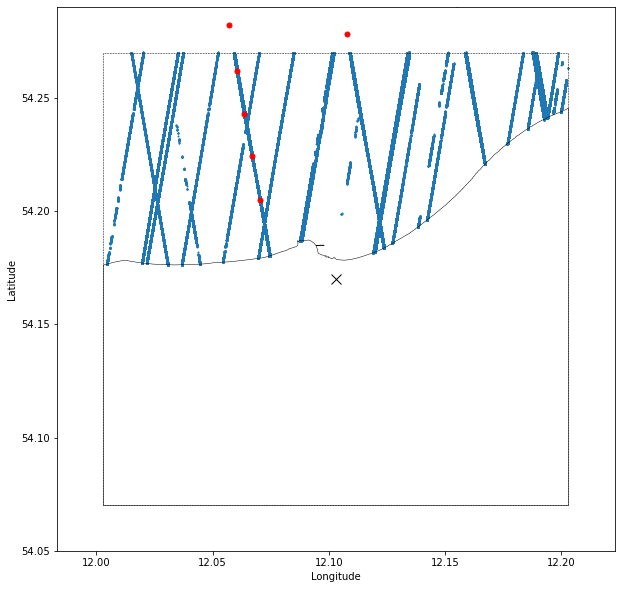

In [4]:
# input_file = '/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/TG_11_ATL03_high_med_conf_masked_DTU21_filtered_threshold_10_m_GOT4p8.txt'
# input_file = '/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/TG_11_ATL03_high_med_conf_masked_DTU21_filtered_threshold_10_m_FES2014_NO_EXTRAPOLATION.txt'
input_file = '/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/TG_11_ATL03_high_med_conf_masked_DTU21_filtered_threshold_10_m_FES2014.txt'
df = pd.read_csv(input_file,header=None,names=['lon','lat','height','time'],dtype={'lon':'float','lat':'float','height':'float','time':'str'})

gdf_osm = gpd.read_file('/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/TG_11.shp')
gdf_bbox = gpd.read_file('/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/TG_11_bbox.shp')

lon_osm,lat_osm = get_lonlat_gdf(gdf_osm)
lon_bbox,lat_bbox = get_lonlat_gdf(gdf_bbox)

# TG 1
# lon_tg = -4.495
# lat_tg = 48.383
# TG 3
# lon_tg = 0.743
# lat_tg = 51.446
# TG 7
# lon_tg = 8.717
# lat_tg = 53.867
# TG 11
lon_tg = 12.103
lat_tg = 54.170

lon = np.asarray(df.lon)
lat = np.asarray(df.lat)
height = np.asarray(df.height)
time = np.asarray(df.time)

time_datetime = np.asarray([datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f') for t in time])
time_days = np.asarray([t.date() for t in time_datetime])
unique_days = np.unique(time_days)
dt = np.append(0,total_seconds(time_datetime[1:] - time_datetime[:-1]))
idx_new_day = np.append(np.append(0,np.atleast_1d(np.argwhere(dt > 3600).squeeze())),len(df))
unique_days_str = np.asarray([ud.strftime('%Y-%m-%d') for ud in unique_days])


plt.rcParams['figure.figsize'] = [10,10]

plt.plot(lon_tg,lat_tg,'kx',markersize=10)
plt.plot(lon_osm,lat_osm,'k',linewidth=0.5)
plt.plot(lon_bbox,lat_bbox,'k',linestyle='--',linewidth=0.5)
plt.plot(lon_atl12,lat_atl12,'r',linestyle='None',marker='.',markersize=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([np.nanmin(lon_bbox)-0.02,np.nanmax(lon_bbox)+0.02])
plt.ylim([np.nanmin(lat_bbox)-0.02,np.nanmax(lat_bbox)+0.02])
# for i in range(len(idx_new_day)-1):
#     idx_selected_day = np.arange(idx_new_day[i],idx_new_day[i+1])
#     lon_selected = lon[idx_selected_day]
#     lat_selected = lat[idx_selected_day]
#     plt.scatter(lon_selected,lat_selected,s=1)

plt.scatter(lon,lat,s=1)

# plt.savefig('/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/TG_11_GOT4p8.png')
plt.show()



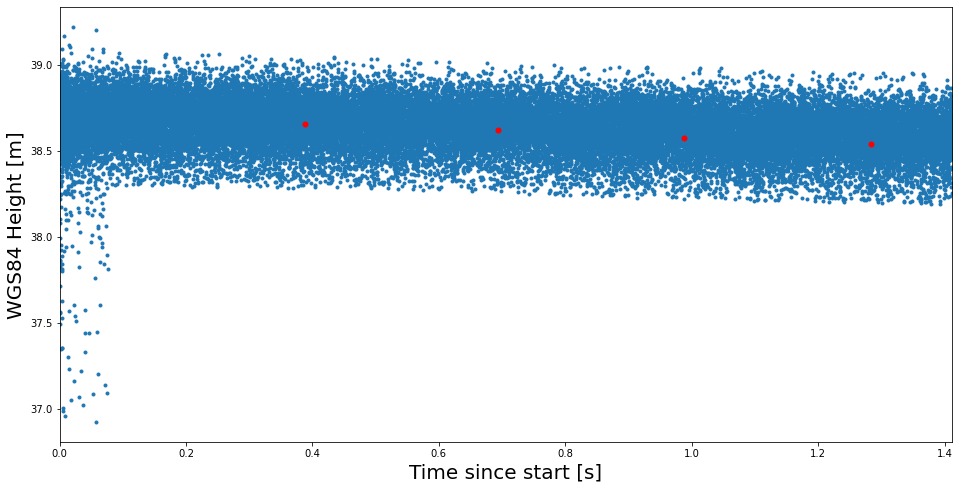

In [15]:
#for ATL03
selected_day = 5 #starts at 0
# selected_day = 8 #starts at 0
# selected_day = 10 #starts at 0
idx_selected_day = np.arange(idx_new_day[selected_day],idx_new_day[selected_day+1])
lon_selected = lon[idx_selected_day]
lat_selected = lat[idx_selected_day]
height_selected = height[idx_selected_day]
time_selected = time[idx_selected_day]
time_datetime_selected = time_datetime[idx_selected_day]
dt_selected = dt[idx_selected_day]

selected_beam = 0 #starts at 0
idx_beam_change = np.append(np.append(0,np.atleast_1d(np.argwhere(dt_selected<0).squeeze())),len(lon_selected))
if selected_beam > len(idx_beam_change)-1:
    print('Selected beam not available for ATL03!')
    exit()

idx_selected_beam = np.arange(idx_beam_change[selected_beam],idx_beam_change[selected_beam+1])
lon_selected = lon_selected[idx_selected_beam]
lat_selected = lat_selected[idx_selected_beam]
height_selected = height_selected[idx_selected_beam]
time_selected = time_selected[idx_selected_beam]
time_datetime_selected = time_datetime_selected[idx_selected_beam]
dt_selected = dt_selected[idx_selected_beam]

#for ATL12
selected_day_atl12 = np.atleast_1d(np.argwhere(unique_days_atl12_str == unique_days_str[selected_day]).squeeze())
idx_selected_day_atl12 = np.arange(idx_new_day_atl12[selected_day_atl12],idx_new_day_atl12[selected_day_atl12+1])

lon_selected_atl12 = lon_atl12[idx_selected_day_atl12]
lat_selected_atl12 = lat_atl12[idx_selected_day_atl12]
height_selected_atl12 = height_atl12[idx_selected_day_atl12]
time_selected_atl12 = time_atl12[idx_selected_day_atl12]
time_datetime_selected_atl12 = time_datetime_atl12[idx_selected_day_atl12]
dt_selected_atl12 = dt_atl12[idx_selected_day_atl12]
idx_beam_change_atl12 = np.append(np.append(0,np.atleast_1d(np.argwhere(dt_selected_atl12<0).squeeze())),len(lon_selected_atl12))
if selected_beam > len(idx_beam_change_atl12)-1:
    print('Selected beam not available for ATL12!')
    exit()
idx_selected_beam_atl12 = np.arange(idx_beam_change_atl12[selected_beam],idx_beam_change_atl12[selected_beam+1])
lon_selected_atl12 = lon_selected_atl12[idx_selected_beam_atl12]
lat_selected_atl12 = lat_selected_atl12[idx_selected_beam_atl12]
height_selected_atl12 = height_selected_atl12[idx_selected_beam_atl12]
time_selected_atl12 = time_selected_atl12[idx_selected_beam_atl12]
time_datetime_selected_atl12 = time_datetime_selected_atl12[idx_selected_beam_atl12]
dt_selected_atl12 = dt_selected_atl12[idx_selected_beam_atl12]


plt.rcParams['figure.figsize'] = [16, 8]
plt.plot(total_seconds(time_datetime_selected-time_datetime_selected[0]),height_selected,marker='.',linestyle='None')
plt.plot(total_seconds(time_datetime_selected_atl12-time_datetime_selected[0]),height_selected_atl12,color='r',marker='.',linestyle='None',markersize=10)
plt.xlabel('Time since start [s]',fontdict={'fontsize':20})
plt.ylabel('WGS84 Height [m]',fontdict={'fontsize':20})
plt.xlim([0,np.nanmax(total_seconds(time_datetime_selected-time_datetime_selected[0]))])
plt.show()

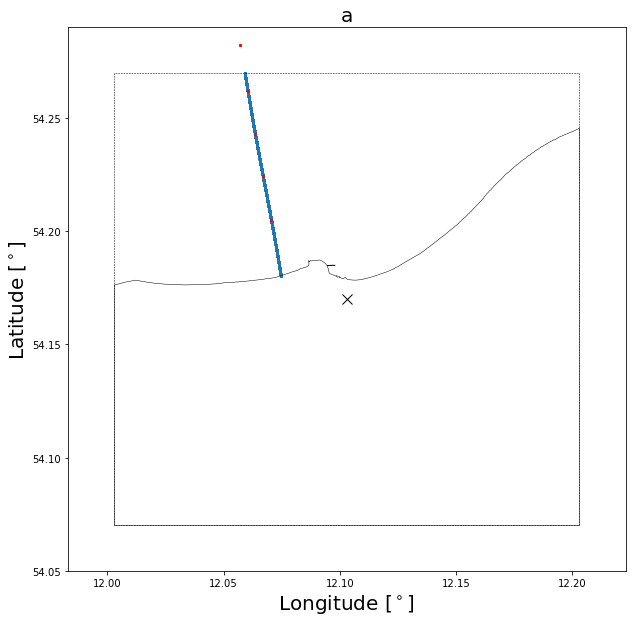

In [8]:
plt.rcParams['figure.figsize'] = [10,10]
plt.plot(lon_tg,lat_tg,'kx',markersize=10)
plt.plot(lon_osm,lat_osm,'k',linewidth=0.5)
plt.plot(lon_bbox,lat_bbox,'k',linestyle='--',linewidth=0.5)
plt.scatter(lon_selected,lat_selected,s=1)
plt.scatter(lon_selected_atl12,lat_selected_atl12,s=5,color='r')
plt.xlabel('Longitude [$^\circ$]',fontdict={'fontsize':20})
plt.ylabel('Latitude [$^\circ$]',fontdict={'fontsize':20})
plt.xlim([np.nanmin(lon_bbox)-0.02,np.nanmax(lon_bbox)+0.02])
plt.ylim([np.nanmin(lat_bbox)-0.02,np.nanmax(lat_bbox)+0.02])
plt.title('a',fontdict={'fontsize':20})
plt.savefig(f'/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/TG_11_ATL03_FES2014_{unique_days_str[selected_day]}_beam_{selected_beam}.png')
plt.show()

Total points:  42048
Noise: 5.12%
Cluster 0: 94.65%
Cluster 1: 0.09%
Cluster 2: 0.06%
Cluster 3: 0.08%


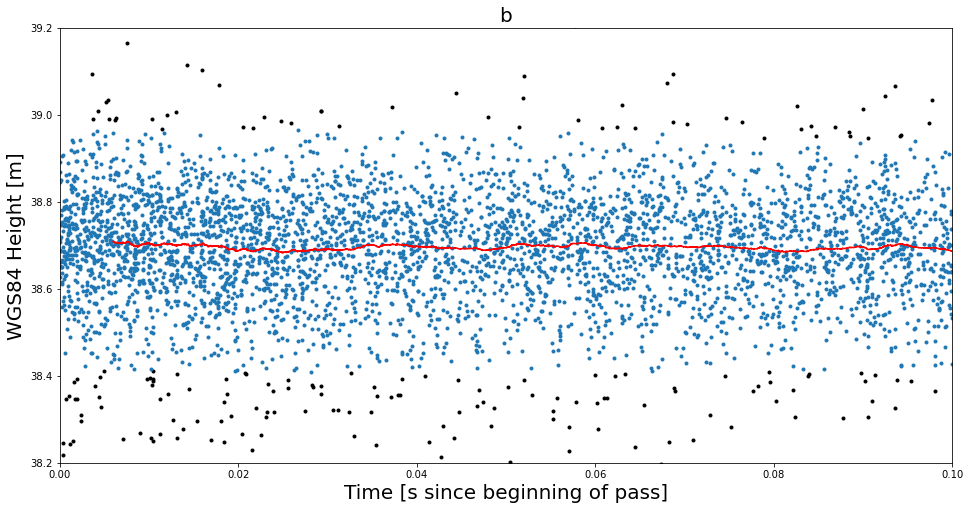

In [18]:
X = StandardScaler().fit_transform(np.vstack((total_seconds(time_datetime_selected-time_datetime_selected[0]),height_selected)).T)
db = DBSCAN(eps=0.10, min_samples=30).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Total points: ',len(labels))
print('Noise: %.2f%%' % (100*n_noise_/len(lon_selected)))
for i in range(n_clusters_):
    # print('Cluster %i: %.2f%%' % (i,100*np.sum(labels==i)/len(lon_selected)))
    print('Cluster %i: %.2f%%' % (i,100*list(labels).count(i)/len(lon_selected)))

plt.rcParams['figure.figsize'] = [16, 8]
plt.plot(total_seconds(time_datetime_selected-time_datetime_selected[0])[labels==-1],height_selected[labels==-1],color='k',marker='.',linestyle='None')
for i in range(n_clusters_):
    plt.plot(total_seconds(time_datetime_selected-time_datetime_selected[0])[labels==i],height_selected[labels==i],color='C'+str(i),marker='.',linestyle='None')
# plt.plot(total_seconds(time_datetime_selected-time_datetime_selected[0])[labels>0],height_selected[labels>0],color='r',marker='.',linestyle='None')
movmean_window = 400

moving_mean_orig = np.asarray(pd.Series(height_selected).rolling(movmean_window).mean())
moving_mean_cluster = np.asarray(pd.Series(height_selected[labels==0]).rolling(movmean_window).mean())

# plt.plot(total_seconds(time_datetime_selected-time_datetime_selected[0]),moving_mean_orig,color='r')
plt.plot(total_seconds(time_datetime_selected-time_datetime_selected[0])[labels==0],moving_mean_cluster,color='r')
plt.plot(total_seconds(time_datetime_selected_atl12-time_datetime_selected[0]),height_selected_atl12,color='w',marker='.',linestyle='None',markersize=10)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.xlabel('Time [s since beginning of pass]',fontdict={'fontsize':20})
plt.ylabel('WGS84 Height [m]',fontdict={'fontsize':20})
# plt.xlim([0,np.nanmax(total_seconds(time_datetime_selected-time_datetime_selected[0]))])
# plt.xlim([0.0,0.1])
# plt.ylim([38.2,39.2])

plt.title('b',fontdict={'fontsize':20})
# plt.savefig('/home/heijkoop/Desktop/TG_Analysis_2022/TG_11/TG_11_ATL03_ATL12_Beam_20190921_cluster_zoomed.png')
plt.show()


0.11605366852552516
0.1403740909518354
0.040232821413330164


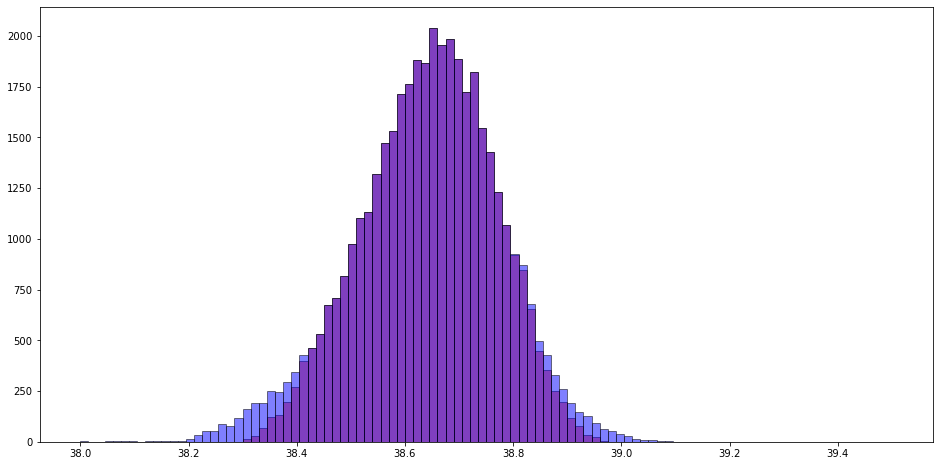

In [35]:
fig, ax = plt.subplots(1, 1)



# fig.suptitle('Horizontally stacked subplots')
ax.hist(height_selected[labels==0], bins=100, range=(38.0, 39.5),color='r',alpha=0.5,histtype='bar', ec='black')
ax.hist(height_selected, bins=100, range=(38.0, 39.5),color='b',alpha=0.5,histtype='bar', ec='black')
print(np.std(height_selected[labels==0]))
print(np.std(height_selected))
print(np.std(moving_mean_cluster[~np.isnan(moving_mean_cluster)]))